## Introduction

The Breakthrough Listen instrument at the Green Bank Telescope (GBT) is a digital spectrometer, which takes incoming raw data from the telescope (amounting to hundreds of TB per day) and performs a Fourier Transform to generate a spectrogram. These spectrograms, also referred to as filterbank files, or dynamic spectra, consist of measurements of signal intensity as a function of frequency and time.
Using these spectrograms, we need to identify anomalous signals in scans of Breakthrough Listen targets.

## Light EDA
Let's import all the libraries we need:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import random 
import os
from tqdm import tqdm, notebook

import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.utils.data.sampler import WeightedRandomSampler
import torch.cuda.amp as amp

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

!pip install timm
import timm

     |████████████████████████████████| 376 kB 285 kB/s eta 0:00:01


A function to set the seeds for reproducibility:

In [2]:
# Set the seeds of the entire notebook
def set_seed(seed = int):
    np.random.seed(seed)
    random_state = np.random.RandomState(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)
    return random_state

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

# Reproducibility
seed         = 55
random_state = set_seed(seed)

Let's load the data:

In [3]:
train_dir = '/kaggle/input/seti-breakthrough-listen/train/'
test_dir  = '/kaggle/input/seti-breakthrough-listen/test/'
df        = pd.read_csv('/kaggle/input/seti-breakthrough-listen/train_labels.csv')

# Make one column for the filepath
df['path'] = train_dir + df['id'].str[0] + '/' + df['id'] + '.npy'

print(f"No. positive class: {np.sum(df['target'] == 1)}")
print(f"No. negative class: {np.sum(df['target'] == 0)}")

No. positive class: 6000
No. negative class: 54000


Approximately 90% to 10% ratio for class imbalance. Let's setup the resampling strategy:

In [4]:
no_CV_folds = 5

# Stratified CV
skf      = StratifiedKFold(n_splits = no_CV_folds, shuffle = True, random_state = random_state)
skf      = list(skf.split(df['id'], df['target']))

Let's have a look at a couple of files:

In [5]:
# Function to plot one file given its ID
def plot_file(file_path):
    
    # Load data
    data = np.load(file_path)
    
    # Make plot
    no_plots = data.shape[0]
    plt.subplots(no_plots, 1, sharex = True, figsize = (10,10))
    
    for idx in range(no_plots):
        
        plt.subplot(no_plots, 1, idx + 1)
        plt.imshow(data[idx].astype(float), aspect = 'auto')
        plt.title(data.shape[1:3])
                    
    return

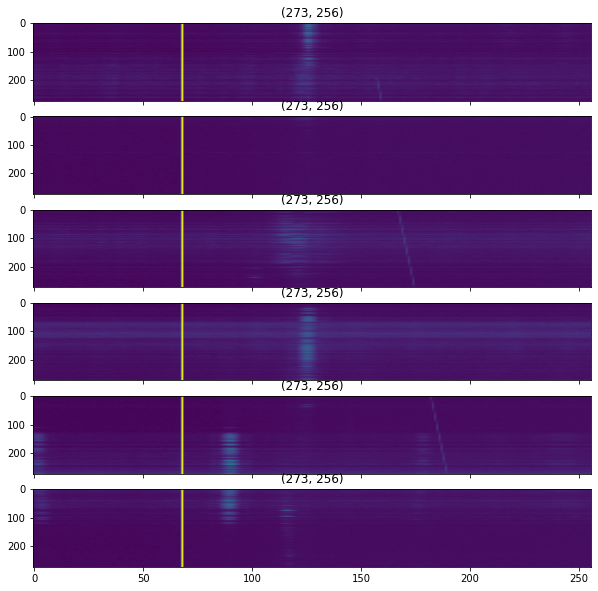

In [7]:
plot_file(df[df['target'] == 1]['path'].iloc[1])

From the competition:

One method we use to isolate candidate technosignatures from RFI is to look for signals that appear to be coming from particular positions on the sky. Typically we do this by alternating observations of our primary target star with observations of three nearby stars: 5 minutes on star “A”, then 5 minutes on star “B”, then back to star “A” for 5 minutes, then “C”, then back to “A”, then finishing with 5 minutes on star “D”. One set of six observations (ABACAD) is referred to as a “cadence”. Since we’re just giving you a small range of frequencies for each cadence, we refer to the datasets you’ll be analyzing as “cadence snippets”.

Not all of the “needle” signals look like diagonal lines, and they may not be present for the entirety of all three “A” observations, but what they do have in common is that they are only present in some or all of the “A” observations (panels 1, 3, and 5 in the cadence snippets).

So, we can take advantage of the fact that we expect the needles to appear in *some* of panels 1, 3, 5. We can train only one those panels, essentially cutting the dataset size by half



## Model Class

Let's setup a class for the ANNs we'll be developing later on. This will be essentially a class that takes as inputs the name of the pretrained model that will be used (imported by timm), a boolean flag indicating if the weights will be randomly initialised, or if a pretrained model will be used, and two more flags indicating if the ANN will be trained channel-wise or spatial-wise, and whether or not half the cadence will be used.

All this will allow us to have a boiler-plate code that will allow for faster experimentation:

In [ ]:
# New classifier
class HeadClassifier(nn.Module):
    
    def __init__(self, input_feats):
        super().__init__()
        
        self.fc = nn.Linear(input_feats, 1)
        nn.init.xavier_uniform_(self.fc.weight)
        
    def forward(self, X):
        
        X = self.fc(X)
        
        return X

# Entire model
class ANN(nn.Module):
    
    def __init__(self, base_name, pretrained = False, spatial = True, AOnly = True):
        super().__init__()
        
        # Get the no. of input channels
        in_channels = ANN.get_input_channels(spatial, AOnly)
        
        # Get baseline
        self.base = timm.create_model(base_name, 
                                      pretrained  = pretrained, 
                                      in_chans    = in_channels, 
                                      num_classes = 1)
        
        try: # EfficientNets
            # Make new classifier
            self.new = HeadClassifier(self.base.classifier.in_features)

            # Forward the input of the baseline classifier
            self.base.classifier = nn.Identity()
            
        except: # NFNet
            # Make new classifier
            self.new = HeadClassifier(self.base.head.fc.in_features)

            # Forward the input of the baseline classifier
            self.base.head.fc = nn.Identity()
            
    
    # Forward phase
    def forward(self, X):
        X = self.base(X)
        X = self.new(X)
        return X
    
    # Freeze all layers of the baseline
    def freeze_base(self):
    
        for name, param in model.base.named_parameters():
            param.requires_grad = False
    
    # Unfreeze all layers
    def unfreeze_all(self):
    
        for name, param in model.named_parameters():
            param.requires_grad = True
    
    @staticmethod
    def get_input_channels(spatial, AOnly):
        
        # Spatial - channel-wise training
        if spatial:
            in_channels = 1
        else:
            if AOnly:
                in_channels = 3
            else:
                in_channels = 6
                
        return in_channels

Let's make sure it works:

In [ ]:
# Forward some data
model = ANN(base_name = 'efficientnet_b0', pretrained = True, spatial = True, AOnly = True) #  eca_nfnet_l0

x = torch.randn(4, 1, 224, 224)
y_hat = model(x).detach()
y_hat

In [ ]:
# Freeze and print only trainable parameters
model.freeze_base()
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)

In [ ]:
# Unfreeze and print non-trainable parameters
model.unfreeze_all()
for name, param in model.named_parameters():
    if not param.requires_grad:
        print(name)

Perfect

## Dataloaders

Next up, we need to setup our dataset class and the dataloader.
The dataset class will take as inputs the dataframe with the file paths and the corresponding targets, the same two flags as the ANN class, as well as the set of transformations that will be used during training.

The dataloader class will subsequently return the dataloader to be used for training / validation and inference:

In [ ]:
# Make the dataset class
class SetiDataset(torch.utils.data.Dataset):
    
    def __init__(self, df, spatial = True, AOnly = True, transform = None):
        # Initialisation function            
        self.labels    = df['target'].values
        self.img_dir   = df['path'].values
        self.transform = transform
        self.spatial   = spatial # False: Channel-wise
        self.AOnly     = AOnly   # True: Read half the cadence
        
    def __len__(self):
        # Return no. samples in the dataset
        return len(self.labels)
    
    def __getitem__(self, idx):
        # Return a sample from the dataset
        
        # Get cadence
        X = np.load(self.img_dir[idx]).astype(np.float32) # shape: 6 x 273 x 256
        
        if self.AOnly:
            X = X[[0, 2, 4]]    # shape: 3 x 273 x 256
        
        if self.spatial:
            X = np.vstack(X)    # shape: (3 x 273 or 6 x 273) x 256
            X = np.transpose(X) # shape: 256 x (3 x 273 or 6 x 273)
            X = np.expand_dims(X, 0) # Add channel dimension. shape: 1 x 256 x (3 x 273 or 6 x 273)
        
        # Get label
        y = self.labels[idx] # np.array shape: 32
        y = torch.as_tensor(y, dtype = torch.float) # tensor shape: 32
        y = y.unsqueeze(0) # tensor shape 32 x 1
        
        # Apply transformation on the cadence
        if self.transform is None:
            X = torch.as_tensor(X, dtype = torch.float)
        else:
            if self.spatial: # Albumentations reshapes on transform. Before and after transforms ensure consistensy
                X = np.transpose(X, [2, 1, 0]) # Reshape prior to transform. shape: (3 x 273 or 6 x 273) x 256 x 1
                X = self.transform(image = X)["image"]
                X = np.transpose(X, [0, 2, 1]) # Reshape prior to transform. shape: 1 x 256 x (3 x 273 or 6 x 273)
            else: 
                pass
            
        return X, y

    
# Make data sampler (to balance the batch target distribution)
def make_sampler(target_arr):
    
    target          = torch.from_numpy(target_arr).long()
    class_count     = np.array([len(np.where(target == t)[0]) for t in np.unique(target)])
    weight          = 1. / class_count
    samples_weight  = np.array([weight[t] for t in target])
    sampler         = WeightedRandomSampler(weights = samples_weight, num_samples = len(samples_weight))
    
    return sampler


# Make dataloader
def make_loader(df, batch_size, transform = None,  spatial = True,  AOnly = True, 
                shuffle = True, balance_sample = False, num_workers = 4, pin_memory = True, drop_last = False):
    
    # Make dataset
    dataset = SetiDataset(df, transform = transform, spatial = spatial, AOnly = AOnly)
    
    # Make the resampler if needed
    if balance_sample: 
        sampler = make_sampler(df['target'].values)
        shuffle = False # Mutually exclusive
    else:
        sampler = None
    
    # Reproducibility
    g = torch.Generator()
    g.manual_seed(0)

    # Make the data loader
    loader = DataLoader(dataset, 
                        batch_size     = batch_size, 
                        shuffle        = shuffle, 
                        sampler        = sampler, 
                        num_workers    = num_workers, 
                        pin_memory     = pin_memory, 
                        drop_last      = drop_last,
                        worker_init_fn = seed_worker,
                        generator      = g)
    
    return loader

## Mixup

Also, we need a class to perform Mixup. Mixup trains a neural network on convex combinations of pairs of examples and their labels. By doing so, mixup regularizes the neural network to favor simple linear behavior in-between training examples. 

In [ ]:
class MixUp(object):
    
    def __init__(self, a = 0.4): # 0.4 -> Suggested in the original paper
        self.a         = a
        self.lamda     = None
        
    def make_multiplier(self):
        
        lamda = np.random.beta(self.a, self.a) # Dims: batch_size x 1
        self.lamda = np.max([lamda, 1 - lamda]) # Avoid duplicates
        
        return
        
    def permute_batch(self, b_size):
        return torch.randperm(b_size)
    
    def compute_target(self, y1, y2):
        # Just for verification
        return y1 * self.lamda + y2 * (1 - self.lamda)
        
    def make_batch(self, X, y):
        
        # Utilising a smart (faster) implementation found here: https://forums.fast.ai/t/mixup-data-augmentation/22764
        idx_arr_s  = self.permute_batch(X.shape[0])

        # Make multiplier for the targets
        self.make_multiplier()

        # Make new predictors
        X = self.lamda * X + (1 - self.lamda) * X[idx_arr_s, :, :, :]

        # Make new targets
        y1, y2 = y, y[idx_arr_s]
        
        # Convert lamda to torch
        return X, y1, y2

## LR Range Test

Moreover, we need a class that will allow us to perform a learning rate range test, given the (untrained) ANN and the dataloader:

In [ ]:
class LRTest(object):
    
    def __init__(self, data, skf, min_lr = 1e-6, max_lr = 1, no_iter = 100):
        self.no_iter    = no_iter
        self.max_lr     = max_lr
        self.min_lr     = min_lr
        self.device     = None
        self.mixup      = None
        self.data       = data
        self.fold_ids   = skf
        self.mult       = (max_lr / min_lr) ** (1 / (no_iter - 1))
        self.dataiter   = None
    
    
    def init_train(self, config, fold):

        self.device = "cuda:0" if torch.cuda.is_available() else "cpu"              # Setup device
        self.mixup  = MixUp(config['mixup_A']) if config['mixup_A'] is not None else None # Setup mixup
        criterion   = nn.BCEWithLogitsLoss()                                        # Criterion
        scaler      = amp.GradScaler() if config['amp_enable'] else None            # Scaler
        model       = ANN(base_name  = config['mdl_base'],                          # Model
                          pretrained = config['mdl_pretrain'], 
                          spatial    = config['spatial_in'], 
                          AOnly      = config['AOnly']);
        if config['mdl_freeze']: 
            model.freeze_base()
            
        optimizer = optim.AdamW(model.parameters(), lr = self.min_lr, weight_decay = config['weight_decay'])
        scheduler = optim.lr_scheduler.MultiplicativeLR(optimizer, lr_lambda = lambda x: self.mult)

        # Make dataloader
        train_idx, val_idx = self.fold_ids[fold] # Grab data for this fold
        dataloader = make_loader(self.data.loc[train_idx], 
                                   batch_size = config['batch_size'],
                                   transform  = config['train_transform'],
                                   spatial    = config['spatial_in'],
                                   AOnly      = config['AOnly'],
                                   balance_sample = False, shuffle = True, num_workers = 4, pin_memory = True, drop_last = True)
        self.dataiter = iter(dataloader)
        
        return model, criterion, scaler, optimizer, scheduler, dataloader
    
    
    # Function to perform the learning rate range test on one experiment
    def __call__(self, config, fold):
        
        model, criterion, scaler, optimizer, scheduler, dataloader = self.init_train(config, fold)
        loss_arr, lr_arr     = [], [] 
        cur_iter, best_loss  = 0, 1e9
        model.to(self.device);

        with tqdm(total = self.no_iter) as pbar:
            
            while cur_iter < self.no_iter:
                
                # Grab last learning rate (before stepping the scheduler)
                lr_arr.append(scheduler.get_last_lr()[0])
                
                # Train a batch
                cur_loss = self.train_batch(model, criterion, optimizer, scheduler, scaler, dataloader)
                
                # Append loss/learning rate to arrays
                loss_arr.append(cur_loss)

                # Check for divergence and exit if needed
                if cur_loss < best_loss: 
                    best_loss = cur_loss

                if cur_loss > 2e2 * best_loss: # Divergence
                    print('Diverged on iteration ' + str(cur_iter) + ' with loss ' + str(cur_loss))
                    break

                # Update progress bar
                pbar.set_postfix(loss = cur_loss)
                pbar.update(1)
                cur_iter += 1

        pbar.close() # Close

        # Make dataframe with results
        res = pd.DataFrame({"lr" : lr_arr, "train_loss" : loss_arr}).set_index('lr')
        res.columns = ['BTS = ' + str(config['batch_size']) + ', WD = ' + str(config['weight_decay'])]

        return res
    
    
    # Return a batch
    def grab_batch(self, dataloader):
            
        try:
            X, y = next(self.dataiter)
        except StopIteration: # End of dataset -> restart
            dataiter = iter(dataloader)
            X, y     = next(self.dataiter)
                
        return X, y
    
    
    # Train batch
    def train_batch(self, model, criterion, optimizer, scheduler, scaler, dataloader):

        model.train()
        optimizer.zero_grad()
        cur_loss = 0
            
        if self.mixup is not None:
            cur_loss += self.train_mixup(model, criterion, scaler, dataloader)    
        else:
            cur_loss += self.train_plain(model, criterion, scaler, dataloader)
                    
        # Update all
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()
        cur_loss = cur_loss.item()

        return cur_loss
    
    
    # Train a batch w/ MixUp loss
    def train_mixup(self, model, criterion, scaler, dataloader):
            
        X, y      = self.grab_batch(dataloader)
        X, y1, y2 = self.mixup.make_batch(X, y)
        X, y1, y2 = X.to(self.device), y1.to(self.device), y2.to(self.device)
                    
        if scaler is not None:
            with amp.autocast():
                y_hat = model(X)
                loss  = self.mixup.lamda * criterion(y_hat, y1) + (1 - self.mixup.lamda) * criterion(y_hat, y2)
                scaler.scale(loss).backward()
        else:
            y_hat = model(X)
            loss  = self.mixup.lamda * criterion(y_hat, y1) + (1 - self.mixup.lamda) * criterion(y_hat, y2)
            loss.backward()
                
        return loss
    
    
    # Train a batch w/ actual loss
    def train_plain(self, model, criterion, scaler, dataloader):
            
        X, y = self.grab_batch(dataloader)
        X, y = X.to(self.device), y.to(self.device)
                    
        if scaler is not None:
            with amp.autocast():
                y_hat = model(X)
                loss  = criterion(y_hat, y)
                scaler.scale(loss).backward()
        else:
            y_hat = model(X)
            loss  = mixup.lamda * criterion(y_hat, y1) + (1 - mixup.lamda) * criterion(y_hat, y2)
            loss.backward()
                
        return loss
    
    
    @staticmethod
    def plot_LR_test(results_df, rolling_window, figsize):
        
        fig, ax = plt.subplots(1, 1, figsize = figsize)
        lr_test_res.rolling(window = rolling_window).mean().plot(kind = 'line', marker = None, logx = True, legend = True, grid = True, ax = ax);
        ax.set_title('Learning Rate Range Test')
        ax.set_ylabel('Loss')
        ax.set_xlabel('Learning Rate')
        
        return

## Trainer

Finally, we need another class that will perform the learning phase of the ANN, given a configuration dictionary. This will allow for easier iterations on different setups:

In [ ]:
class EarlyStopping():
    
    def __init__(self, patience = 5, min_delta = 0):
        self.patience   = patience
        self.min_delta  = min_delta
        self.counter    = 0
        self.best_loss  = None
        self.early_stop = False
        self.save       = True
    
    
    def __call__(self, val_loss):
        
        if self.best_loss == None:
            self.counter   = 0
            self.best_loss = val_loss
            self.save      = True
            
        elif self.best_loss - val_loss > self.min_delta:
            self.counter   = 0
            self.best_loss = val_loss
            self.save      = True
            
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            self.save    = False
            
            if self.counter >= self.patience:
                self.early_stop = True
                self.save    = False

                
# Train / validate
class Trainer():
    
    
    def __init__(self, data, fold_ids, save = False):
        self.data              = data
        self.skf               = fold_ids
        self.save              = save
        self.chekpoint_dirname = None
        self.plot_dirname      = None
        self.pred_dirname      = None
    
    
    # Make dataloaders
    def make_dataloaders(self, config, fold):
        
        train_idx, val_idx = self.skf[fold] # Grab data for this fold
        
        train_loader = make_loader(self.data.loc[train_idx], 
                                   batch_size = config['batch_size'], 
                                   transform  = config['train_transform'], 
                                   spatial    = config['spatial_in'], 
                                   AOnly      = config['AOnly'], 
                                   balance_sample = False, shuffle = True, num_workers = 4, pin_memory = True, drop_last = True)

        val_loader   = make_loader(self.data.loc[val_idx], 
                                   batch_size = config['batch_size'], 
                                   transform  = config['val_transform'], 
                                   spatial    = config['spatial_in'], 
                                   AOnly      = config['AOnly'], 
                                   balance_sample = False, shuffle = False, num_workers = 4, pin_memory = True, drop_last = False)
        
        return train_loader, val_loader
    
    
    # Setup model
    @staticmethod
    def make_model(config):
        
        model = ANN(base_name = config['mdl_base'], pretrained = config['mdl_pretrain'], spatial = config['spatial_in'], AOnly = config['AOnly']);
        
        if config['mdl_freeze']: model.freeze_base()
            
        return model
    
    
    # Setup the optimiser
    @staticmethod
    def make_optimizer(config, model, learn_rate, weight_decay):
        
        optimizer = optim.AdamW(model.parameters(), lr = learn_rate, weight_decay = weight_decay)
        
        return optimizer

    @staticmethod
    def make_scheduler(optimizer, train_loader, config):
        scheduler = optim.lr_scheduler.OneCycleLR(optimizer, 
                                                  max_lr          = config['learn_rate'], 
                                                  steps_per_epoch = len(train_loader), epochs = config['no_epochs'], 
                                                  anneal_strategy = 'cos', 
                                                  cycle_momentum  = False, 
                                                  pct_start       = config['pct_start'], 
                                                  div_factor      = config['div_factor'])
        
        return scheduler
    
    
    # Setup training
    def setup_train(self, config, fold):

        # Make directories
        self.chekpoint_dirname = '/kaggle/working/' + config['exp_name'] + '_fold_' + str(fold) + '.pth' # Directory to save the model state dict etc.
        self.plot_dirname      = '/kaggle/working/' + config['exp_name'] + '_fold_' + str(fold) + '.png' # Directory to save plot
        self.pred_dirname      = '/kaggle/working/' + config['exp_name'] + '_fold_' + str(fold) + '.npy' # Directory to save plot
        
        # Seup objects
        device     = "cuda:0" if torch.cuda.is_available() else "cpu"   # Setup device
        criterion  = nn.BCEWithLogitsLoss()                             # Criterion
        scaler     = amp.GradScaler() if config['amp_enable'] else None # Scaler
        model      = self.make_model(config)
        mixup      = MixUp(config['mixup_A']) if config['mixup_A'] is not None else None 
        early_stop = EarlyStopping(config['patience'], config['min_delta']) if config['early_stop'] else None
        train_loader, val_loader = self.make_dataloaders(config, fold) # Data loaders

        # Setup scheduler and optimizer
        if config['scheduler'] == 'OneCycle':
            optimizer = self.make_optimizer(config, model, config['learn_rate'] / config['div_factor'], config['weight_decay'])
            scheduler = self.make_scheduler(optimizer, train_loader, config)
        else:
            optimizer = self.make_optimizer(config, model, config['learn_rate'], config['weight_decay'])
            scheduler = None

        return device, mixup, model, criterion, scaler, optimizer, train_loader, val_loader, scheduler, early_stop


    # Training loop
    @staticmethod
    def train_loop(model, device, mixup, criterion, optimizer, scheduler, scaler, train_loader, loop):

        model.train()
        running_loss = 0

        for batch_idx, (X, y) in enumerate(train_loader):
            
            # Mixup
            if mixup is not None:
                X, y1, y2 = mixup.make_batch(X, y)
                X, y1, y2 = X.to(device), y1.to(device), y2.to(device)
            else:
                X, y = X.to(device), y.to(device)

            optimizer.zero_grad()

            if scaler is not None: # amp
                with amp.autocast():
                    y_hat = model(X)
                    if mixup is not None:
                        loss  = mixup.lamda * criterion(y_hat, y1) + (1 - mixup.lamda) * criterion(y_hat, y2)
                    else: # No mixup
                        loss = criterion(y_hat, y)

                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()

            else: # no amp
                y_hat = model(X)
                if mixup is not None:
                    loss  = mixup.lamda * criterion(y_hat, y1) + (1 - mixup.lamda) * criterion(y_hat, y2)
                else:
                    loss = criterion(y_hat, y)
                loss.backward()
                optimizer.step()
            
            # Update
            if scheduler is not None: scheduler.step()
            running_loss += loss.item()
            loop.set_description(f"Training Batch [{batch_idx + 1} / {len(train_loader)}: loss = {round(loss.item(), 4)}]")

        running_loss /= len(train_loader)
        
        lr = scheduler.get_last_lr() if scheduler is not None else optimizer.param_groups[0]['lr']

        return running_loss, lr

    
    # Validation loop
    @staticmethod
    def validation_loop(model, device, criterion, scaler, val_loader, loop):

        model.eval()
        running_loss   = 0
        targets, preds = [], []

        with torch.no_grad():
            for batch_idx, (X, y) in enumerate(val_loader):
                X = X.to(device)
                y = y.to(device)

                if scaler is not None:
                    with amp.autocast():
                        y_hat = model(X)
                else:
                    y_hat = model(X)

                loss  = criterion(y_hat, y)
                running_loss += loss.item()
                targets.extend(y.cpu().numpy().tolist())
                preds.extend(np.concatenate(y_hat.cpu().numpy()).tolist())
                loop.set_description(f"Validation Batch [{batch_idx + 1} / {len(val_loader)}: loss = {round(loss.item(), 4)}]")
                
        running_loss /= len(val_loader)
        val_auc = roc_auc_score(targets, preds)

        return running_loss, val_auc, preds

    
    # Save training process
    def make_checkpoint(self, model, optimizer, scheduler, scaler, epoch, val_loss, val_auc, val_predictions):

        sched_dict  = scheduler.state_dict() if scheduler is not None else None
        scaler_dict = scaler.state_dict() if scaler is not None else None
        
        checkpoint = {'model'     : model.state_dict(),
                      'optimizer' : optimizer.state_dict(),
                      'scheduler' : sched_dict,
                      'scaler'    : scaler_dict,
                      'epoch'     : epoch,
                      'val_loss'  : val_loss,
                      'val_auc'   : val_auc}

        torch.save(checkpoint, self.chekpoint_dirname)
        np.save(self.pred_dirname, np.array(val_predictions))
    
        return
    
    
    @staticmethod
    def load_checkpoint(config, model, optimizer, scheduler, scaler):
        
        print('Loading checkpoint')
        checkpoint = torch.load(config['load_checkpoint'])
        
        model.load_state_dict(checkpoint['model'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        
        if config['scheduler'] is not None:
            scheduler.load_state_dict(checkpoint['scheduler'])
            
        if config['scaler'] is not None:
            scaler.load_state_dict(checkpoint['scaler'])
            
        epoch    = checkpoint['epoch']
        val_loss = checkpoint['val_loss']
        val_auc  = checkpoint['val_auc']
            
        return model, optimizer, scheduler, scaler, epoch, val_loss, val_auc
    
    # Train
    def __call__(self, config, fold):
        
        # Setup
        device, mixup, model, criterion, scaler, optimizer, train_loader, val_loader, scheduler, early_stop = self.setup_train(config, fold)
        
        # Load checkpoint
        if config['load_checkpoint'] is not None:
            model, optimizer, scheduler, scaler, epoch, val_loss, val_auc = self.load_checkpoint(config, model, optimizer, scheduler, scaler)
        else:
            cur_epoch = 0
        
        # Setup loop
        loop      = tqdm(range(cur_epoch, config['no_epochs']))
        stats     = {"epoch":[], "train_loss":[], "val_loss":[], "val_auc": [], "lr": []}
        model.to(device);

        for epoch in loop:

            train_loss, train_lr     = self.train_loop(model, device, mixup, criterion, optimizer, scheduler, scaler, train_loader, loop)
            val_loss, val_auc, preds = self.validation_loop(model, device, criterion, scaler, val_loader, loop)
            
            # Early stopping and checkpointing
            if config['early_stop']:
                early_stop(val_loss)
                if early_stop.early_stop: break
            
            if config['early_stop']:
                if early_stop.save and self.save: 
                    self.make_checkpoint(model, optimizer, scheduler, scaler, epoch, val_loss, val_auc, preds)
            else:
                if self.save:
                    self.make_checkpoint(model, optimizer, scheduler, scaler, epoch, val_loss, val_auc, preds)
            
            # Append statistics
            stats["epoch"].append(epoch)
            stats["train_loss"].append(train_loss)
            stats["lr"].append(train_lr)
            stats["val_loss"].append(val_loss)
            stats["val_auc"].append(val_auc)

            # Update progress bar
            if config['early_stop']:
                loop.set_postfix(train_loss = train_loss, val_loss = val_loss, val_auc = val_auc, early_stopping = early_stop.counter)
            else:
                loop.set_postfix(train_loss = train_loss, val_loss = val_loss, val_auc = val_auc)
            
        return stats
    
    def plot(self, stats, fold):
        
        # Plot results
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 3))

        ax1.plot(stats['epoch'], stats['val_loss'])
        ax1.plot(stats['epoch'], stats['train_loss'])
        ax1.legend(['Val loss', 'Train loss'])
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')

        ax2.plot(stats['epoch'], stats['val_auc'])
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Val ROC - AUC')
        fig.suptitle('Fold ' + str(fold));
        plt.show()
        
        if self.save:
            fig.savefig(self.plot_dirname)
        
        return


In [ ]:
# Small wrapper to run multiple LR tests
def run_LR_tests(df, skf, config, batch_sizes, w_decays, fold_no = 0):
    
    LRT, res = LRTest(df, skf), []
    for (batch_size, w_decay) in itertools.product(batch_sizes, w_decays):
        
        config['batch_size'], config['weight_decay'] = batch_size, w_decay
        res.append(LRT(config, fold = fold_no))

    return pd.concat(res, axis = 1) # Make dataframe from experiments

## Dataset Transformations

Let's make a dict here to quickly change the transformations on the fly:

In [ ]:
transformations = {
    'val_RES': lambda H, W: A.Compose([A.Resize(height = H, width = W, interpolation = 1, p = 1), ToTensorV2()]),
    'val_plain' : ToTensorV2(),
    'train_HVF_SSR_RES' : lambda H, W: A.Compose([A.HorizontalFlip(p = 0.5), 
                              A.VerticalFlip(p = 0.5),
                              A.ShiftScaleRotate(shift_limit = 0.1, scale_limit = 0.1, rotate_limit = 10, p = 0.5),
                              A.Resize(height = H, width = W, interpolation = 1, p = 1),
                              ToTensorV2()]),
    'train_HVF_SSR' : A.Compose([A.HorizontalFlip(p = 0.5), 
                                 A.VerticalFlip(p = 0.5),
                                 A.ShiftScaleRotate(shift_limit = 0.1, scale_limit = 0.1, rotate_limit = 10, p = 0.5),
                                 ToTensorV2()]),
 'train_plain'  : ToTensorV2()
}

## Training

In the following, given the configuration dictionary defined below, we'll be using all the classes defined above, to perform a learning rate range test where needed, along with the learning phase.

First let's define the configuration dict:

In [ ]:
config = dict(
    no_epochs       = 10,
    early_stop      = False, # Enable early stopping (True / False)
    patience        = 3,     # Max. epochs to enable early stopping
    min_delta       = 0.005, # Dloss to increment early stopping counter
    batch_size      = 32,
    mdl_base        = 'efficientnet_b1', # Baseline model
    mdl_pretrain    = True,
    mdl_freeze      = False, # Freeze model backbone
    mixup_A         = None,   # Alpha coefficient for mixup (set to None to de-activate)
    spatial_in      = True,  # Train spatial-wise or channel-wise
    AOnly           = True,  # Use entire cadence or the A observations only
    learn_rate      = 6e-4,  # Max. learning rate to be used
    weight_decay    = 1e-2,
    scheduler       = 'OneCycle',
    train_transform = transformations['train_HVF_SSR_RES'](512, 512),
    val_transform   = transformations['val_RES'](512, 512),
    exp_name        = 'Enetb1_Spatial_AOnly_HVF_SSR_RES_512_512_1CycleLR_6e4_1e4_WD1e2_pct_01',
    load_checkpoint = None, # Whether to load everything from a checkpoint
    amp_enable      = True, # Enable AMP
    div_factor      = 6,
    pct_start       = 0.1
)

Let's perform a learning rate range test, to identify a working range for this configuration:

In [ ]:
batch_sizes = [32]
w_decays    = [0, 1e-4, 1e-3, 1e-2]
lr_test_res = run_LR_tests(df, skf, config, batch_sizes, w_decays)

LRTest.plot_LR_test(lr_test_res, rolling_window = 10, figsize = (15, 7)); # Plot
plt.ylim([0.2, 1]);
plt.savefig(config['exp_name'] + '_lr_test.png')

And now we can train the ANN:

In [ ]:
T = Trainer(df, skf, save = True)

for fold in range(no_CV_folds):
    stats = T(config, fold = fold)
    T.plot(stats, fold = fold)

## Inference

We need a bit of code to generate the dataloader for the test set and to perform inference:

In [ ]:
def evaluate(data_loader, model):
    
    device        = "cuda:0" if torch.cuda.is_available() else "cpu"   # Setup device
    model.to(device)
    model.eval()
    final_targets = []
    final_outputs = []
    
    with torch.no_grad():
        
        for (X, y) in tqdm(data_loader, position=0, leave=True, desc='Evaluating'):
            
            X = X.to(device)
            y = y.to(device)
            
            output = model(X)
            output = output.detach().cpu().numpy().tolist()
            
            final_outputs.extend(output)
            
    return final_outputs


def predict(model_dir, config, submission, no_CV_folds):
    
    # Make dataloader for the test set
    test_loader = make_loader(submission, 
                              batch_size = config['batch_size'], 
                              transform  = config['val_transform'], 
                              spatial    = config['spatial_in'],
                              AOnly      = config['AOnly'],
                              balance_sample = False, shuffle = False, num_workers = 4, 
                              pin_memory = True, drop_last = False)

    # Compute predictions of each model
    sig  = nn.Sigmoid()
    outs = []

    for fold in range(no_CV_folds):

        # Load model
        model      = ANN(base_name = config['mdl_base'], pretrained = config['mdl_pretrain'], spatial = config['spatial_in'], AOnly = config['AOnly']);
        checkpoint = torch.load(model_dir + config['exp_name'] + '_fold_' + str(fold) + '.pth')
        model.load_state_dict(checkpoint['model'])

        # Predict
        predictions = evaluate(test_loader, model)
        predictions = np.array(predictions)[:,0]
        
        # Apply sigmoid and append to list
        out = sig(torch.from_numpy(predictions))
        out = out.detach().numpy()
        outs.append(out)
        
    return outs

Perfect. Now, we can make our predictions with the models we trained earlier. Due to time and GPU limitations, only 3 configurations were utilised, each trained for 5 folds for 10 epochs.

In [ ]:
enet_b0_dir = '/kaggle/input/enet-spatial-mixup-01-512/'
#enet_b1_dir = '/kaggle/input/enet-b1-spatial-mixup-01-512/'
#enet_b1_dir_nomixup = '/kaggle/input/enet-b1-no-mixup/'

# Read submission template
submission         = pd.read_csv('../input/seti-breakthrough-listen/sample_submission.csv')
submission['path'] = submission['id'].apply(lambda x:f'../input/seti-breakthrough-listen/test/{x[0]}/{x}.npy')

# Predict
outs   = predict(enet_b1_dir, config, submission, no_CV_folds = no_CV_folds)

Perfect. Now we can make our submissions:

In [ ]:
# Average predictions from the model in each fold and update dataframe
pred = np.mean(np.array(outs), axis = 0)
submission.target  = pred
submission['path'] = submission['id'].apply(lambda x:f'../input/seti-breakthrough-listen/test/{x[0]}/{x}.npy')
submission.drop(['path'], axis = 1, inplace = True)
submission.to_csv('submission_b1_no_mixup.csv', index = False)
submission.head()

All three configurations give an average CV score (ROC-AUC) of around 0.85, with a 0.757 score on the leaderboard.
## Model Stacking
Let's see if the use of a meta-model can help a bit:

### Read out-of-fold predictions
Let's read the the OOF predictions of each ANN that will make up the level-1 dataset:

In [ ]:
oof_dir = '/kaggle/input/setioofpredictions/'
oof_data = []
sig      = nn.Sigmoid()

for fold in range(no_CV_folds):
    _, val_idx     = skf[fold] # Grab validation set for this fold
    read_substring = 'fold_' + str(fold)
    fold_data      = np.empty((val_idx.shape[0], 4)) # Empty array to hold results for this fold
    fold_data[:]   = np.nan # Fill with nan
    
    fold_data[:,0] = df['target'].iloc[val_idx] # Column 0: Actual target
    mdl_idx = 1 # Counter for model predictions (Columns 1-4)
    
    # Read data
    for _,_,files in os.walk(oof_dir):
        for file in sorted(files):
            if read_substring in file:
                preds = np.load(oof_dir + file) # Load file
                preds = torch.from_numpy(preds) # Convert to tensor
                preds = sig(preds)              # Apply sigmoid
                preds = preds.numpy()           # Convert to numpy
                fold_data[:, mdl_idx] = preds   # Add to matrix
                mdl_idx += 1                    # Increment model (column) counter
    # Append targets and predictions to list
    oof_data.append(fold_data)

oof_data = np.vstack(oof_data)

### Logistic Regression

We'll use a simple logistic regressor as our meta model, trained with the OOF predictions of the 3 ANNs we built earlier, using a 5-fold CV resampling strategy for hyperparameter tuning:

In [ ]:
# define dataset
X = oof_data[:, 1:]
y = oof_data[:, 0]

# Define resampling strategy
cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 1)

# define / run grid search
grid_search = GridSearchCV(estimator   = LogisticRegression(), 
                           param_grid  = dict(C = np.logspace(np.log10(100), np.log10(1e-2), 50)), 
                           n_jobs      = -1, 
                           cv          = cv,
                           scoring     = 'roc_auc',
                           error_score = 0)

grid_result = grid_search.fit(X, y)
    
# Grab & print results
best_idx    = grid_result.best_index_
best_score  = grid_result.cv_results_['mean_test_score'][best_idx]
best_std    = grid_result.cv_results_['std_test_score'][best_idx]
best_params = grid_result.best_params_

# summarize results
print("Best: %f +- %f using %s" % (best_score, best_std, best_params))

## Submission

Perfect. Now, we can read the predictions of the ANNs built earlier, and make our final predictions with the meta model:

In [ ]:
# Read submission files
def read_submissions(submission_dir):
    
    files = os.listdir(submission_dir)
    dfs   = []

    for idx, file in enumerate(files):
        df = pd.read_csv(submission_dir + file, index_col = 0)
        df.columns = ['pred_' + str(idx)]
        dfs.append(df)
    
    df = pd.concat(dfs, axis = 1)
    
    return df

df = read_submissions('/kaggle/input/seti-submissions/')
mdl = LogisticRegression(C = 0.244205)
mdl.fit(X, y)
df['target'] = mdl.predict_proba(df.values)[:, 1]
df.drop(['pred_0', 'pred_1', 'pred_2'], axis = 1, inplace = True)
df.to_csv('LR_1_submission.csv', index = True)

Indeed, the meta-model increased the LB score to 0.759. If there were not any time (or compute) limitations, the ANNs could have been trained for a higher number of epochs, and more configurations would have been tested.
Nevertheless, a top 20% score was obtained, even though only 3 configurations were tested, each trained for 10 epochs only.